In [19]:
import asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel

In [20]:
from clients import Clients
from mongo.schemas import PoolsSnapshotTrainRegression, PoolsSnapshotTestRegression

mongo_client = Clients.get_mongo_client()

In [21]:
async def load_data():
    await mongo_client.initialize()
    
    # Load Train Data
    print("Loading Train data...")
    train_docs = await PoolsSnapshotTrainRegression.find_many().to_list()
    df_train = pd.DataFrame([doc.dict() for doc in train_docs])
    
    # Load Test Data
    print("Loading Test data...")
    test_docs = await PoolsSnapshotTestRegression.find_many().to_list()
    df_test = pd.DataFrame([doc.dict() for doc in test_docs])
    
    return df_train, df_test

In [22]:
loop = asyncio.get_event_loop()
df_train, df_test = await load_data()

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

2025-12-24 19:54:57,619 INFO [clients.mongo_client] [mongo_client.py:27] [trace_id=0 span_id=0 resource.service.name= trace_sampled=False] - MongoDB client initialized.


Loading Train data...


/tmp/ipykernel_240048/631110861.py:7: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  df_train = pd.DataFrame([doc.dict() for doc in train_docs])


Loading Test data...
Train shape: (4943, 15)
Test shape: (1238, 15)


/tmp/ipykernel_240048/631110861.py:12: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  df_test = pd.DataFrame([doc.dict() for doc in test_docs])


In [23]:
FEATURE_COLUMNS = [
    'tvl_current', 
    'tvl_mean', 
    'tvl_volatility', 
    'max_drawdown', 
    'apy_mean', 
    'apy_std', 
    'chain_score'
]
TARGET_COLUMN = 'risk_score'

# Tách X, y
X_train = df_train[FEATURE_COLUMNS]
y_train = df_train[TARGET_COLUMN]

X_test = df_test[FEATURE_COLUMNS]
y_test = df_test[TARGET_COLUMN]

print("Features:", FEATURE_COLUMNS)

Features: ['tvl_current', 'tvl_mean', 'tvl_volatility', 'max_drawdown', 'apy_mean', 'apy_std', 'chain_score']


In [24]:
### Baseline Model (Chạy thử mặc định)
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Train
rf_base.fit(X_train, y_train)

# Predict
y_pred_base = rf_base.predict(X_test)

# Đánh giá
mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print(f"--- Baseline Performance ---")
print(f"MAE (Sai số tuyệt đối TB): {mae_base:.4f}")
print(f"RMSE (Sai số bình phương TB): {rmse_base:.4f}")
print(f"R2 Score: {r2_base:.4f}")

--- Baseline Performance ---
MAE (Sai số tuyệt đối TB): 0.0963
RMSE (Sai số bình phương TB): 0.1791
R2 Score: 0.9930


In [25]:
### Hyperparameter Tuning (GridSearchCV)
param_grid = {
    'n_estimators': [50, 100, 200],         # Số lượng cây 
    'max_depth': [10, 20, None],            # Độ sâu tối đa
    'min_samples_leaf': [1, 2, 4],          # Số mẫu tối thiểu ở lá 
    'max_features': ['sqrt', 'log2', None]  # Số features khi tách nút
}

print("Bắt đầu Grid Search...")
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,               # Cross-validation 5-fold [cite: 118]
    n_jobs=-1,          # Dùng tất cả CPU core
    scoring='neg_mean_squared_error', # Tiêu chí tối ưu (MSE)
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"\nBest Params: {grid_search.best_params_}")

# Đánh giá Best Model
y_pred_opt = best_model.predict(X_test)
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))

print(f"--- Optimized Performance ---")
print(f"MAE: {mae_opt:.4f} (Cải thiện: {mae_base - mae_opt:.4f})")
print(f"RMSE: {rmse_opt:.4f}")

Bắt đầu Grid Search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Params: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 200}
--- Optimized Performance ---
MAE: 0.0987 (Cải thiện: -0.0024)
RMSE: 0.1842


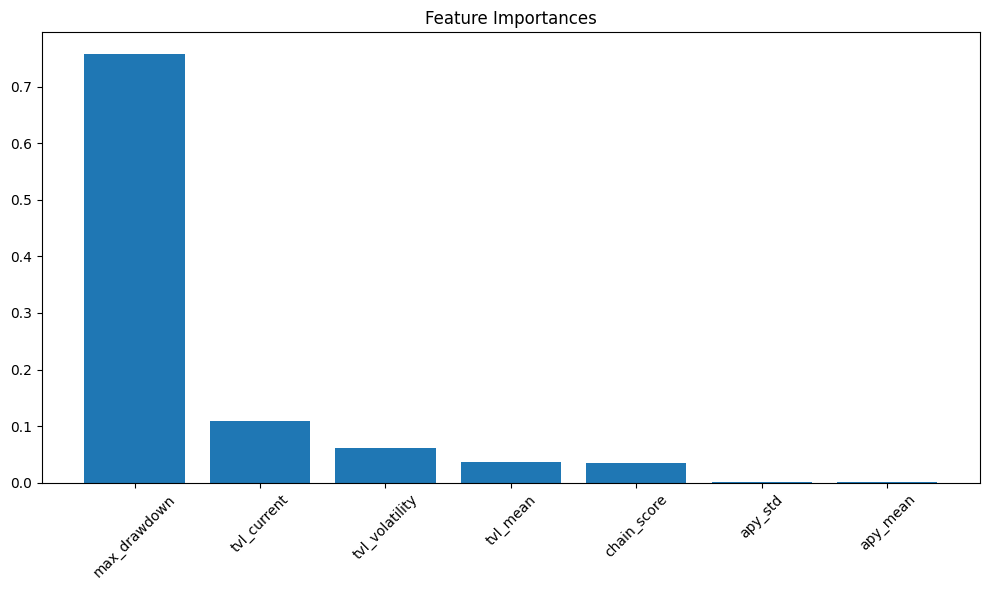

1. max_drawdown: 0.7578
2. tvl_current: 0.1085
3. tvl_volatility: 0.0607
4. tvl_mean: 0.0360
5. chain_score: 0.0355
6. apy_std: 0.0008
7. apy_mean: 0.0007
Original features: 7
Selected features: 1
--- Selected Features Performance ---
MAE: 0.9327
=> Model đầy đủ feature tốt hơn.


In [26]:
### Feature Importance & Selection
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [FEATURE_COLUMNS[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

# In chi tiết
for i in range(X_train.shape[1]):
    print(f"{i+1}. {FEATURE_COLUMNS[indices[i]]}: {importances[indices[i]]:.4f}")


# %% [markdown]
# ### Thử nghiệm: Feature Selection [cite: 377]
# Tự động loại bỏ các feature có độ quan trọng thấp hơn mức trung bình.

# %%
sfm = SelectFromModel(best_model, threshold='mean')
sfm.fit(X_train, y_train)

X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Selected features: {X_train_selected.shape[1]}")

# Train lại mô hình trên tập feature rút gọn
rf_selected = RandomForestRegressor(
    **grid_search.best_params_, 
    random_state=42
)
rf_selected.fit(X_train_selected, y_train)

y_pred_sel = rf_selected.predict(X_test_selected)
mae_sel = mean_absolute_error(y_test, y_pred_sel)

print(f"--- Selected Features Performance ---")
print(f"MAE: {mae_sel:.4f}")

# Quyết định chọn model nào
final_model = best_model
if mae_sel < mae_opt:
    print("=> Model rút gọn tốt hơn, sẽ chọn model này.")
    final_model = rf_selected
    # Lưu ý: Khi deploy cần nhớ filter input feature tương ứng
else:
    print("=> Model đầy đủ feature tốt hơn.")

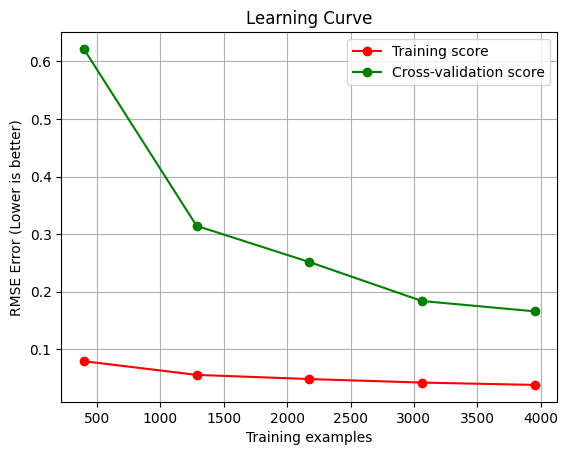

In [27]:
### Learning Curve
# Kiểm tra Overfitting/Underfitting.

# %%
train_sizes, train_scores, test_scores = learning_curve(
    final_model, X_train, y_train, 
    cv=5, scoring='neg_mean_squared_error',
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

# Chuyển đổi score từ negative MSE sang RMSE dương để dễ nhìn
train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("RMSE Error (Lower is better)")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [28]:
# %% [markdown]
# ## 8. Lưu Model
# Lưu model tốt nhất để dùng cho API.

# %%
model_filename = 'risk_score_model_v2.pkl'
joblib.dump(final_model, model_filename)
print(f"Model saved to {model_filename}")

Model saved to risk_score_model_v2.pkl
